### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID Detection'

Mounted at /content/drive
/content/drive/My Drive/COVID Detection


### Importing the required libraries/dependencies

In [2]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Defining the Parameters

In [3]:
IMAGE_SIZE = [150, 150] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'data/ct/CT_COVID'
noncovid_path = 'data/ct/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [4]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['data/ct/CT_COVID/Covid (206).png', 'data/ct/CT_COVID/Covid (1238).png', 'data/ct/CT_COVID/Covid (277).png', 'data/ct/CT_COVID/Covid (275).png', 'data/ct/CT_COVID/Covid (1240).png']
Total Count:  1601
First 5 NonCovid Files:  ['data/ct/CT_NonCOVID/Non-Covid (1122).png', 'data/ct/CT_NonCOVID/Non-Covid (103).png', 'data/ct/CT_NonCOVID/Non-Covid (1137).png', 'data/ct/CT_NonCOVID/Non-Covid (116).png', 'data/ct/CT_NonCOVID/Non-Covid (122).png']
Total Count:  1626


### Fetching all the Images and Class Labels from the dataset

In [5]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(150,150)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(150,150))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualizing Few Images from Dataset

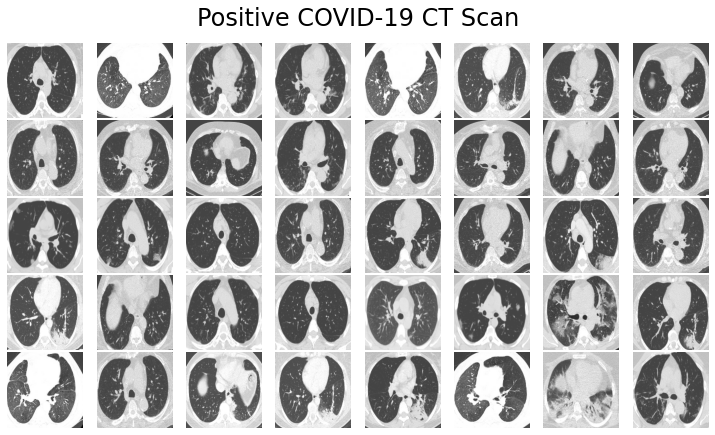

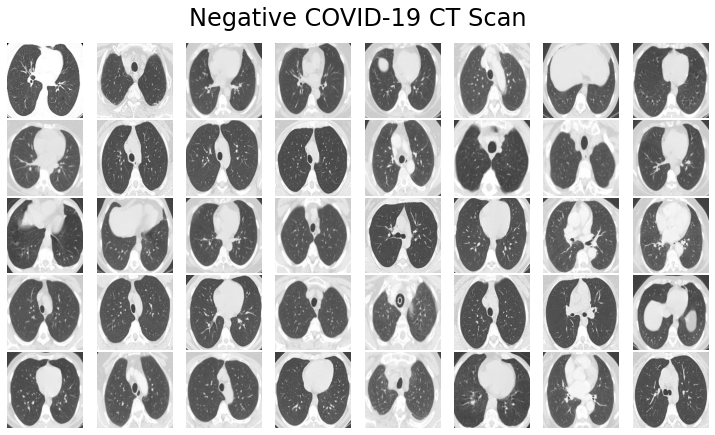

In [6]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization of the dataset before using to train the model**


In [7]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Splitting the Dataset into Training and testing sets**

In [8]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualization of few images from Training and Test sets

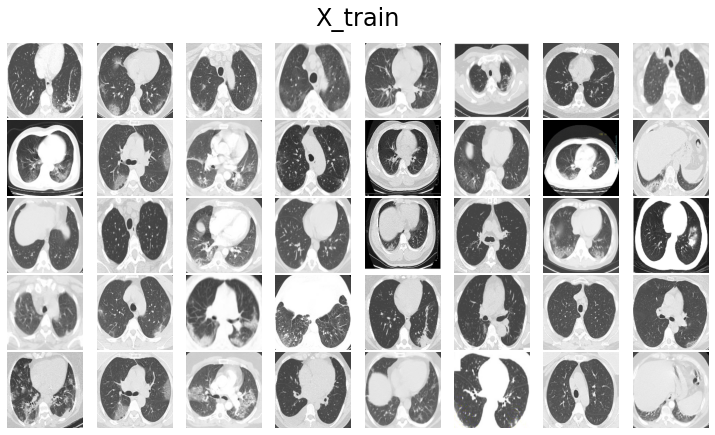

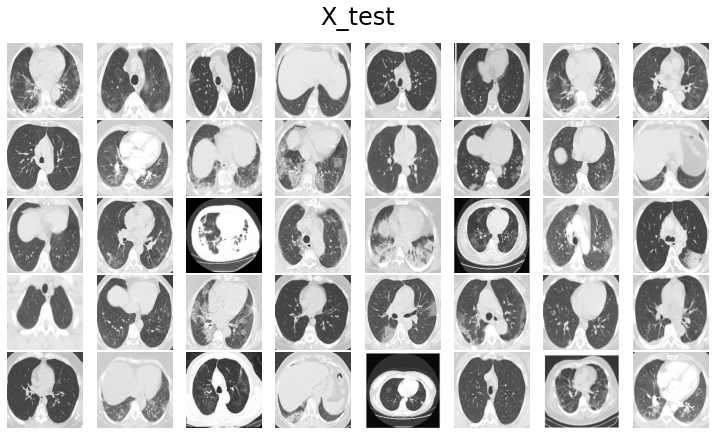

In [9]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building the NASNetLarge model**

In [10]:
NASNetLarge = NASNetLarge(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(150, 150, 3)))

outputs = NASNetLarge.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=NASNetLarge.input, outputs=outputs)

for layer in NASNetLarge.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

343613440/343610240 [==============================] - 2s 0us/step


In [ ]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 74, 74, 96)   2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 74, 74, 96)   384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 96)   0           stem_bn1[0][0]                   
______________________________________________________________________________________________

### **Applying Image Augmentation Technique**
#### To train on images at different positions, angles, flips, etc

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
80/80 [==============================] - 71s 334ms/step - loss: 1.8209 - accuracy: 0.6233 - val_loss: 1.3698 - val_accuracy: 0.6847
Epoch 2/500
80/80 [==============================] - 21s 257ms/step - loss: 1.6945 - accuracy: 0.6895 - val_loss: 1.4906 - val_accuracy: 0.7295
Epoch 3/500
80/80 [==============================] - 21s 258ms/step - loss: 1.7086 - accuracy: 0.7155 - val_loss: 2.0980 - val_accuracy: 0.7156
Epoch 4/500
80/80 [==============================] - 21s 258ms/step - loss: 2.1108 - accuracy: 0.6922 - val_loss: 1.6985 - val_accuracy: 0.7202
Epoch 5/500
80/80 [==============================] - 22s 276ms/step - loss: 1.9253 - accuracy: 0.7035 - val_loss: 1.6933 - val_accuracy: 0.7187
Epoch 6/500
80/80 [==============================] - 21s 260ms/step - loss: 2.0161 - accuracy: 0.7136 - val_loss: 1.9946 - val_accuracy: 0.7249
Epoch 7/500
80/80 [==============================] - 22s 276ms/step - loss: 2.4860 - accuracy: 0.6961 - val_loss: 1.7004 - val_accuracy:

In [13]:
# Save Model and Weights
model.save('NASNetLarge_ct.h5')
model.save_weights('NASNetLarge_weights_ct.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
# Load saved model
model = load_model('NASNetLarge_ct.h5')

### **Making Predicions**

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

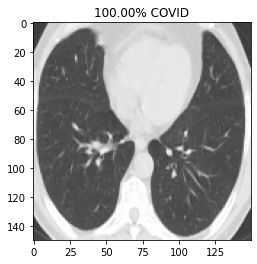

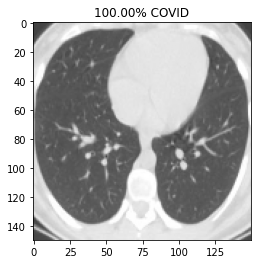

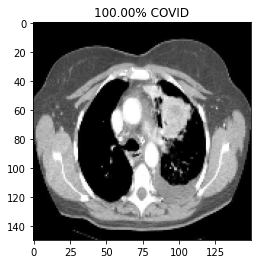

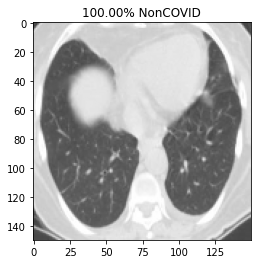

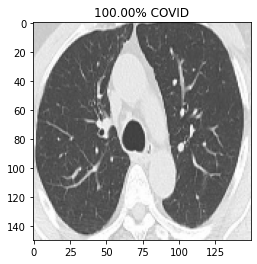

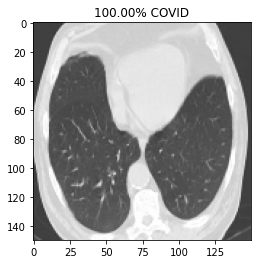

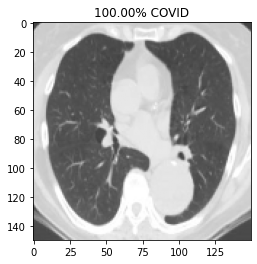

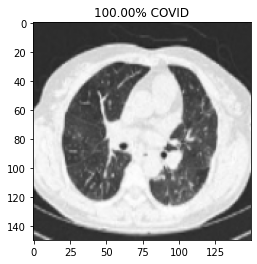

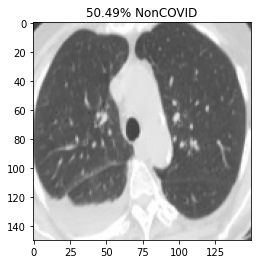

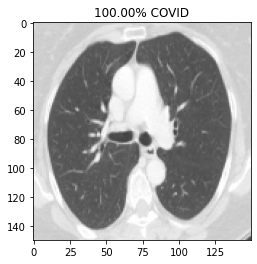

In [16]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [17]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

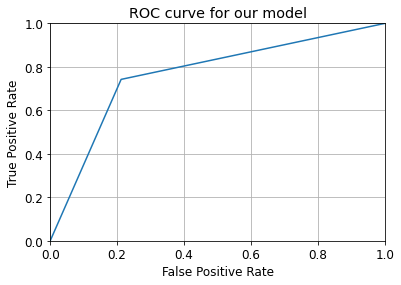

In [19]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


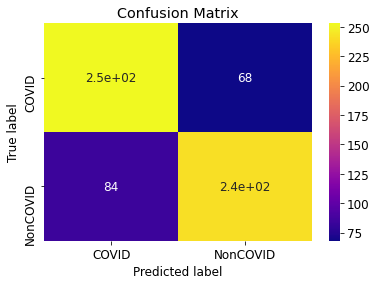

Confusion Matrix with Normalized Values


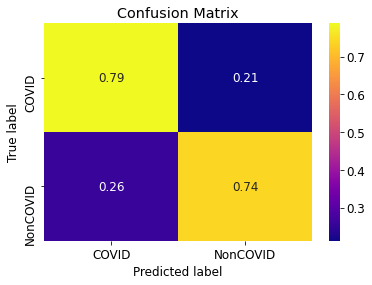

In [20]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       321
           1       0.78      0.74      0.76       326

    accuracy                           0.77       647
   macro avg       0.77      0.77      0.77       647
weighted avg       0.77      0.77      0.76       647



### **Accuracy and Loss Plots**

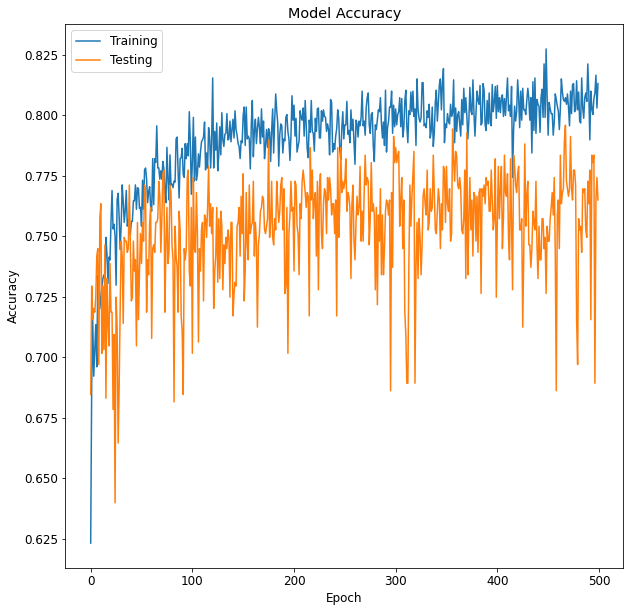

In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('NASNetLarge_ct_accuracy.png')
plt.show()


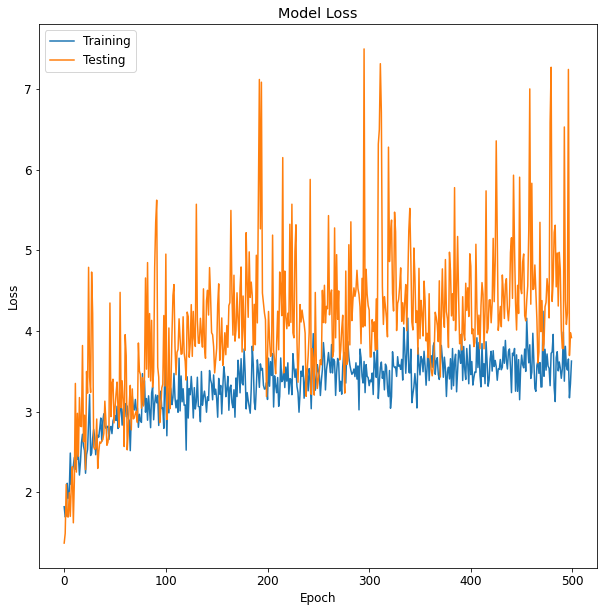

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('NASNetLarge_ct_loss.png')
plt.show()